In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from tqdm import tqdm
import torchvision

c:\Users\wngud\anaconda3\envs\ODE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BATCH_SIZE = 128
train_dataset = datasets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [161]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [162]:
print(train_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [163]:
for (X_train, Y_train) in train_loader:
    print(f"X_train: {X_train.size()} type: {X_train.type()}")
    print(f"Y_train: {Y_train.size()} type: {Y_train.type()}")
    break

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
Y_train: torch.Size([128]) type: torch.LongTensor


In [164]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

https://github.com/soapisnotfat/pytorch-cifar10/blob/master/models/AlexNet.py 참고 


https://github.com/kuangliu/pytorch-cifar 참고

In [165]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using PyTorch version: {torch.__version__}, Device: {DEVICE}")

model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0)


Using PyTorch version: 1.13.1+cu116, Device: cuda


In [166]:
def train(model, train_loader, optimizer, bar):
    model.train()
    total_loss = 0
    total_cnt = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_cnt += image.shape[0]
    return total_loss / total_cnt

In [167]:
def evaluate(model, test_loader, train_loader):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim=True)[1]
            test_correct += prediction.eq(label.view_as(prediction)).sum().item()
    train_correct = 0
    with torch.no_grad():
        for image, label in train_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim=True)[1]
            train_correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_accuracy = 100. * test_correct / len(test_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    return test_accuracy, train_accuracy

In [168]:
EPOCHS = 70
train_loss_save = []
test_loss_save = []
train_acc_save = []
test_acc_save = []
bar = tqdm(range(1, EPOCHS + 1), total=EPOCHS, desc='Train ')
for Epoch in bar:
    train_loss = train(model, train_loader, optimizer, bar)
    test_accuracy, train_accuracy = evaluate(model, test_loader, train_loader)
    scheduler.step()
    bar.set_postfix(
            test_accuracy=f"{test_accuracy:0.3f}",
            train_loss=f"{train_loss:0.3f}",
            train_accuracy=f"{train_accuracy:0.3f}",
        )
    train_acc_save.append(train_accuracy)
    train_loss_save.append(train_loss)
    test_acc_save.append(test_accuracy)

Train : 100%|██████████| 70/70 [21:59<00:00, 18.85s/it, test_accuracy=82.320, train_accuracy=88.724, train_loss=0.003]


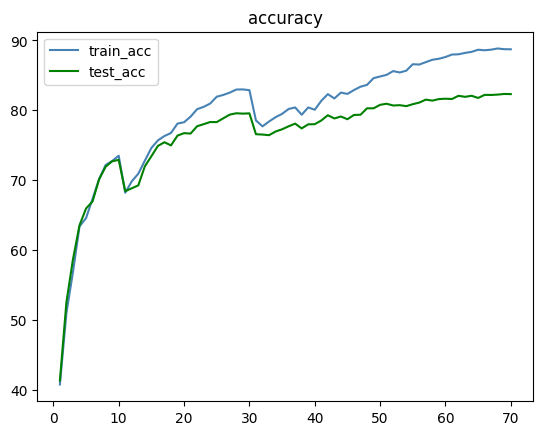

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026687A1E670>
Traceback (most recent call last):
  File "c:\Users\wngud\anaconda3\envs\ODE\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\Users\wngud\anaconda3\envs\ODE\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


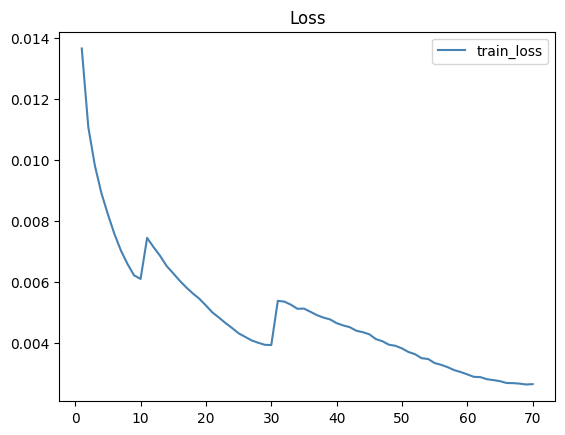

In [169]:
from matplotlib import pyplot as plt
x = [i for i in range (1, EPOCHS+ 1)]


plt.plot(x, train_acc_save, color='steelblue', label = 'train_acc')
plt.plot(x, test_acc_save, color='green', label = 'test_acc')
plt.title('accuracy')
plt.legend()
plt.savefig('./result/result_Alexnet_with_aug_accuracy.png')
plt.show()
# Second Subplot
plt.plot(x, train_loss_save, color='steelblue', label = 'train_loss')
plt.legend()
plt.title('Loss')
plt.savefig('./result/result_Alexnet_with_aug_loss.png')

In [170]:
PATH = './Alexnet_with_aug.pt'
torch.save(model.state_dict(), PATH)

In [171]:
print("train_set : " + str(train_acc_save[-1]))
print("test_set : " + str(test_acc_save[-1]))


train_set : 88.724
test_set : 82.32
